In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

## Direct neighbors

In [35]:
df_results = pd.read_csv("../Results/InvestmentModelResults/Loop_4models_neighbors_only_v2_8760.csv")

In [36]:
#Export revenues and congestion rents should be dealt with with opposite signs
neg_components = ["export_rev","cong_rent_e","cong_rent_i"]
df_results[neg_components] = -df_results[neg_components]

#Split congestion rents equally between neighbors
rents = ['cong_rent_i', 'cong_rent_e']
df_results[rents] = df_results[rents]/2

#Combine operational cost components 
operational_costs = ['CO2_cost', 'load_shedding_cost', 'VOM_cost', 'fuel_cost']
df_results["Operational costs"] = df_results[operational_costs].sum(axis=1)

cost_vals = ['CO2_cost', 'load_shedding_cost', 'VOM_cost', 'fuel_cost','investment_cost', 'export_rev',"import_cost", 'cong_rent_i', 'cong_rent_e']
df_results["Total cost"] = df_results[cost_vals].sum(axis=1)

trade_cost_vals = ['export_rev',"import_cost", 'cong_rent_i', 'cong_rent_e']
df_results["Total trade cost"] = df_results[trade_cost_vals].sum(axis=1)

trade_cost_vals_2 = ["import_cost"]
df_results["Trade cost"] = df_results[trade_cost_vals_2].sum(axis=1)

trade_rev_vals = ['export_rev', 'cong_rent_i', 'cong_rent_e']
df_results["Trade revenue"] = df_results[trade_rev_vals].sum(axis=1)

#Add net import 
df_results["Net import"] = df_results["imported"] - df_results["exported"]

#Add load shedding 
df_results["Load shedding"] = df_results["load_shedding_cost"]/8000

#Add total production
df_results["Total production"] = df_results["w_off_prod"]+ df_results["w_on_prod"]+ df_results["PV_prod"]+df_results["CCGT_prod"]+df_results["OCGT_prod"]

In [37]:

# Assuming df is your DataFrame
new_column_names = {
    'CY': 'CY',
    'CY_ts': 'CY_ts',
    'VOLL': 'VOLL',
    'type': 'type',
    'simplified': 'simplified',
    'investment_cost': 'investment cost',
    'CCGT': 'CCGT',
    'OCGT': 'OCGT',
    'PV': 'PV',
    'w_on': 'w_on',
    'w_off': 'w_off',
    'CCGT_prod': 'CCGT prod',
    'OCGT_prod': 'OCGT prod',
    'PV_prod': 'PV prod',
    'w_on_prod': 'w_on prod',
    'w_off_prod': 'w_off prod',
    'imported': 'imported',
    'exported': 'exported',
    'import_cost': 'import cost',
    'export_rev': 'export revenue',
    'cong_rent_i': 'congestion rent import',
    'cong_rent_e': 'congestion rent export',
    'demand': 'demand',
    'peak_demand': 'peak demand',
    'nb_techs_neighbours': 'nb techs neighbours',
    'time_solve': 'time solve',
    'time_build': 'time build',
    'time_TC': 'time TC',
    'Operational costs': 'Operational costs',
    'Total cost': 'Total cost',
    'Net import': 'Net import',
    'Load shedding': 'Load shedding',
    'Total production': 'Total production',
    'name': 'name',
    'Model Type': 'Model Type'
}

df_results.rename(columns=new_column_names, inplace=True)


In [38]:
def create_model_type_name(row,columns):
    strings = [str(row[col]) for col in columns if pd.notna(row[col])]
    return '-'.join(strings)

In [63]:
##Start with some renaming for clarity 
geo_scope_map = {
    'DE00_NL00_FR00_UK00_BE00_LUG1': 'DN',
    'N_A': ''
}
df_results["geoscope_m"] = df_results["geoscope"].map(geo_scope_map)

# List of columns to consider for joining
columns_to_join = ['type', 'trans_cap_other', 'geoscope_m', 'stepsize']

# Apply the function row-wise to create the new column
df_results['name'] = df_results.apply(create_model_type_name, args=(columns_to_join,), axis=1)

name_map = {
    'NTC-1.0e10-DN': 'SN',
    'NTC-S-DN': "Endo",
    'TCPC-DN': "TCPC",
    "isolated-" : "Isolated",
    "TCS-DN-100.0": "TCS",
    "TCS-DN-1000.0": "TCS-1000",
    "TCS-DN-10.0": "TCS-10",
    "TCS-DN-1.0": "TCS-1",
    "NTC-0-DN": "NTC-0"

}
df_results['Model Type'] = df_results["name"].replace(name_map)

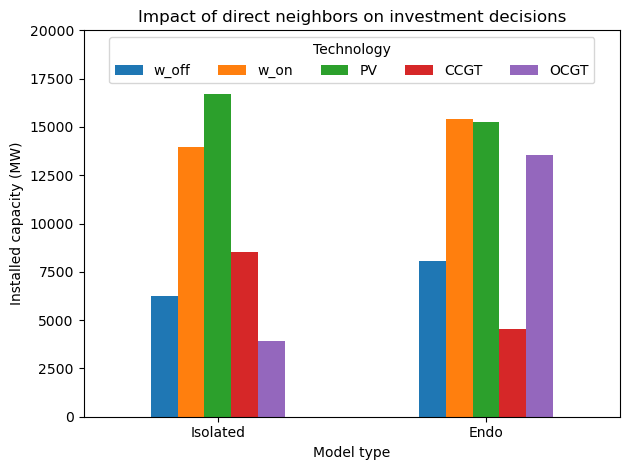

In [68]:
## Plot installed capacities 

# Define the types to include and order in which you want the types to appear
type_order = [name_map["isolated-"],name_map["NTC-S-DN"]]
filter_condition = df_results["Model Type"].isin(type_order)

filtered_df = df_results[filter_condition].set_index("Model Type").reindex(type_order).reset_index()

#Choose the values to be displayed
stacked = False
if stacked: 
    vals= ["CCGT", "OCGT","PV","w_on","w_off"]
else:
    vals = [ "w_off", "w_on","PV","CCGT", "OCGT"]


filtered_df.plot.bar(x="Model Type", y=vals, stacked=stacked)
plt.xticks(rotation=0) 
plt.xlabel('Model type')
plt.ylabel('Installed capacity (MW)')
if stacked: 
    plt.ylim((0,70000))
else:
    plt.ylim((0,20000))
plt.title('Impact of direct neighbors on investment decisions')
plt.legend(title='Technology',loc = "upper center",ncols = 5)
plt.tight_layout()
plt.savefig("../Results/Figures/PhD-Day/isolated_vs_endo_caps.png")

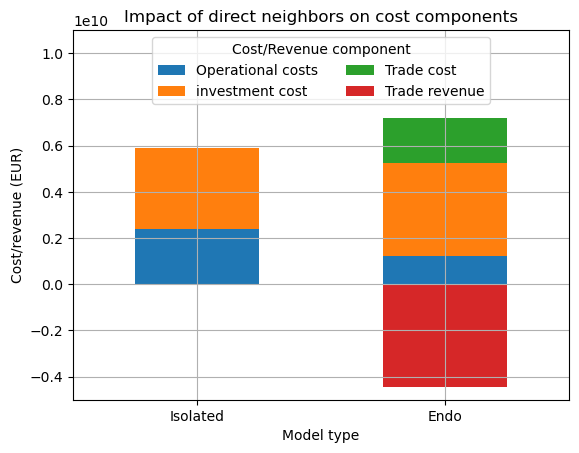

In [74]:
##Plot cost components
# Define the types to include and order in which you want the types to appear

type_order = [name_map["isolated-"],name_map["NTC-S-DN"]]

fig, ax = plt.subplots(1)
filter_condition = df_results["Model Type"].isin(type_order)

filtered_df = filtered_df = df_results[filter_condition].set_index("Model Type").reindex(type_order).reset_index()

vals = ["Operational costs",
       'investment cost', "Trade cost", "Trade revenue"]
vals_tot = vals
#vals_tot = "Total cost"

#vals = ["imported","exported"]

stacked = True
filtered_df.plot.bar(x="Model Type", y=vals_tot, stacked=stacked,ax = ax)

# # Scatter plot for multiple columns with different colors
# scatter_columns = ['Total cost', 'Total trade cost']
# colors = ['black', 'yellow']  # Define colors for each scatter plot

# for col, color in zip(scatter_columns, colors):
#     filtered_df.plot.scatter(x="Model Type", y=col, ax=ax, label=col, color=color)
# # filtered_df.plot.scatter(x="Model Type", y=["Total cost","Total cost"],ax = ax)
# # filtered_df.plot.scatter(x="Model Type", y="Total trade cost",ax = ax,label = "Total cost")

plt.xlabel('Model type')
plt.ylabel('Cost/revenue (EUR)')
plt.title('Impact of direct neighbors on cost components')
plt.legend(title='Cost/Revenue component',ncols = 2,loc = "upper center")
plt.xticks(rotation=0) 
if stacked: 
    plt.ylim((-5e9,11e9))    
else: 
    plt.ylim((-5e9,12e9))
plt.grid(True)  # Adding grid
plt.savefig("../Results/Figures/PhD-Day/isolated_vs_endo_costs.png")

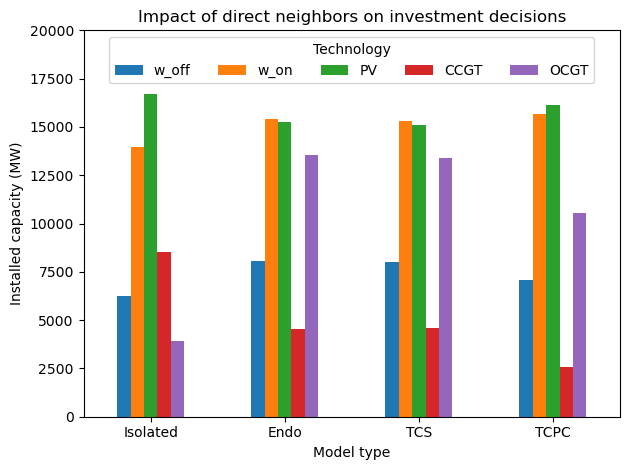

In [69]:
## Plot installed capacities 

# Define the types to include and order in which you want the types to appear
# type_order = ["Isolated","Endogenous neighbors","Trade curves system","Trade curves per country"]
type_order = [name_map["isolated-"],name_map["NTC-S-DN"],name_map["TCS-DN-100.0"],name_map["TCPC-DN"]]
filter_condition = df_results["Model Type"].isin(type_order)

filtered_df = df_results[filter_condition].set_index("Model Type").reindex(type_order).reset_index()

#Choose the values to be displayed
stacked = False
if stacked: 
    vals= ["CCGT", "OCGT","PV","w_on","w_off"]
else:
    vals = [ "w_off", "w_on","PV","CCGT", "OCGT"]


filtered_df.plot.bar(x="Model Type", y=vals, stacked=stacked)
plt.xticks(rotation=0) 
plt.xlabel('Model type')
plt.ylabel('Installed capacity (MW)')
if stacked: 
    plt.ylim((0,70000))
else:
    plt.ylim((0,20000))
plt.title('Impact of direct neighbors on investment decisions')
plt.legend(title='Technology',loc = "upper center",ncols = 5)
plt.tight_layout()
plt.savefig("../Results/Figures/PhD-Day/dn_caps.png")

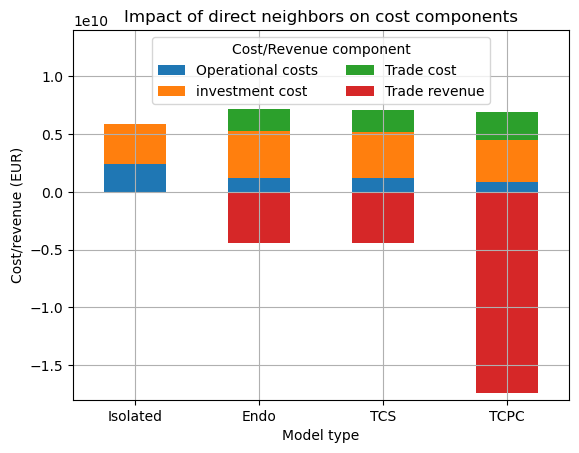

In [77]:
##Plot cost components
# Define the types to include and order in which you want the types to appear

type_order = [name_map["isolated-"],name_map["NTC-S-DN"],name_map["TCS-DN-100.0"],name_map["TCPC-DN"]]

fig, ax = plt.subplots(1)
filter_condition = df_results["Model Type"].isin(type_order)

filtered_df = filtered_df = df_results[filter_condition].set_index("Model Type").reindex(type_order).reset_index()

vals = ["Operational costs",
       'investment cost', "Trade cost", "Trade revenue"]
vals_tot = vals
#vals_tot = "Total cost"

#vals = ["imported","exported"]

stacked = True
filtered_df.plot.bar(x="Model Type", y=vals_tot, stacked=stacked,ax = ax)

# # Scatter plot for multiple columns with different colors
# scatter_columns = ['Total cost', 'Total trade cost']
# colors = ['black', 'yellow']  # Define colors for each scatter plot

# for col, color in zip(scatter_columns, colors):
#     filtered_df.plot.scatter(x="Model Type", y=col, ax=ax, label=col, color=color)
# # filtered_df.plot.scatter(x="Model Type", y=["Total cost","Total cost"],ax = ax)
# # filtered_df.plot.scatter(x="Model Type", y="Total trade cost",ax = ax,label = "Total cost")

plt.xlabel('Model type')
plt.ylabel('Cost/revenue (EUR)')
plt.title('Impact of direct neighbors on cost components')
plt.legend(title='Cost/Revenue component',ncols = 2,loc = "upper center")
plt.xticks(rotation=0) 
if stacked: 
    plt.ylim((-18e9,14e9))    
else: 
    plt.ylim((-5e9,15e9))
plt.grid(True)  # Adding grid
plt.savefig("../Results/Figures/PhD-Day/dn_costs.png")

## Indirect neighbors

In [78]:
df_results = pd.read_csv("../Results/InvestmentModelResults/Loop_4models_indirect_neighbors_v2_8760.csv")

In [79]:
#Export revenues and congestion rents should be dealt with with opposite signs
neg_components = ["export_rev","cong_rent_e","cong_rent_i"]
df_results[neg_components] = -df_results[neg_components]

#Split congestion rents equally between neighbors
rents = ['cong_rent_i', 'cong_rent_e']
df_results[rents] = df_results[rents]/2

#Combine operational cost components 
operational_costs = ['CO2_cost', 'load_shedding_cost', 'VOM_cost', 'fuel_cost']
df_results["Operational costs"] = df_results[operational_costs].sum(axis=1)

cost_vals = ['CO2_cost', 'load_shedding_cost', 'VOM_cost', 'fuel_cost','investment_cost', 'export_rev',"import_cost", 'cong_rent_i', 'cong_rent_e']
df_results["Total cost"] = df_results[cost_vals].sum(axis=1)

trade_cost_vals = ['export_rev',"import_cost", 'cong_rent_i', 'cong_rent_e']
df_results["Total trade cost"] = df_results[trade_cost_vals].sum(axis=1)

trade_cost_vals_2 = ["import_cost"]
df_results["Trade cost"] = df_results[trade_cost_vals_2].sum(axis=1)

trade_rev_vals = ['export_rev', 'cong_rent_i', 'cong_rent_e']
df_results["Trade revenue"] = df_results[trade_rev_vals].sum(axis=1)

#Add net import 
df_results["Net import"] = df_results["imported"] - df_results["exported"]

#Add load shedding 
df_results["Load shedding"] = df_results["load_shedding_cost"]/8000

#Add total production
df_results["Total production"] = df_results["w_off_prod"]+ df_results["w_on_prod"]+ df_results["PV_prod"]+df_results["CCGT_prod"]+df_results["OCGT_prod"]

In [80]:
# Assuming df is your DataFrame
new_column_names = {
    'CY': 'CY',
    'CY_ts': 'CY_ts',
    'VOLL': 'VOLL',
    'type': 'type',
    'simplified': 'simplified',
    'investment_cost': 'investment cost',
    'CCGT': 'CCGT',
    'OCGT': 'OCGT',
    'PV': 'PV',
    'w_on': 'w_on',
    'w_off': 'w_off',
    'CCGT_prod': 'CCGT prod',
    'OCGT_prod': 'OCGT prod',
    'PV_prod': 'PV prod',
    'w_on_prod': 'w_on prod',
    'w_off_prod': 'w_off prod',
    'imported': 'imported',
    'exported': 'exported',
    'import_cost': 'import cost',
    'export_rev': 'export revenue',
    'cong_rent_i': 'congestion rent import',
    'cong_rent_e': 'congestion rent export',
    'demand': 'demand',
    'peak_demand': 'peak demand',
    'nb_techs_neighbours': 'nb techs neighbours',
    'time_solve': 'time solve',
    'time_build': 'time build',
    'time_TC': 'time TC',
    'Operational costs': 'Operational costs',
    'Total cost': 'Total cost',
    'Net import': 'Net import',
    'Load shedding': 'Load shedding',
    'Total production': 'Total production',
    'name': 'name',
    'Model Type': 'Model Type'
}

df_results.rename(columns=new_column_names, inplace=True)

In [81]:
geo_scope_map = {
    'A_l_l': 'All',
    'DE00_NL00_FR00_UK00_BE00': 'DN',
    'N_A': ''
}
df_results["geoscope_m"] = df_results["geoscope"].replace(geo_scope_map)

# List of columns to consider for joining
columns_to_join = ['type', 'trans_cap_other', 'geoscope_m']

# Apply the function row-wise to create the new column
df_results['name'] = df_results.apply(create_model_type_name, args=(columns_to_join,), axis=1)

name_map = {
    'NTC-1.0e10-DN': 'SN-DN',
    'NTC-1.0e10-All': 'SN-All',
    'NTC-S-All': "NTC-All",
    'NTC-S-DN': "NTC-DN",
    'TCPC-All': "TCPC-All",
    'TCPC-DN': "TCPC",
    
}
df_results['Model Type'] = df_results["name"].replace(name_map)


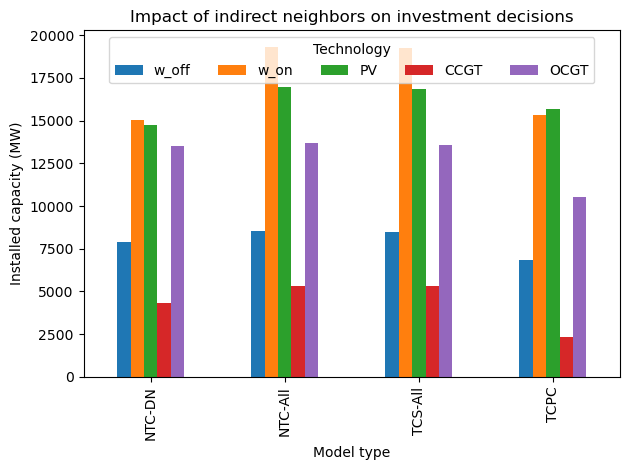

In [85]:
## Plot installed capacities 

# Define the types to include and order in which you want the types to appear
type_order = ["NTC-DN", "NTC-All", "TCS-All","TCPC"]
filter_condition = df_results["Model Type"].isin(type_order)
filtered_df = df_results[filter_condition].set_index("Model Type").reindex(type_order).reset_index()
#filtered_df = dev_df[filter_condition].set_index("Model Type").reindex(type_order).reset_index()

#Choose the values to be displayed
stacked = False
if stacked: 
    vals= ["CCGT", "OCGT","PV","w_on","w_off"]
else:
    vals = [ "w_off", "w_on","PV","CCGT", "OCGT"]
    #vals= ["CCGT_dev", "OCGT_dev","PV_dev","w_on_dev","w_off_dev"]
#vals = ["imported","exported"]


filtered_df.plot.bar(x="Model Type", y=vals, stacked=stacked)

plt.xlabel('Model type')
plt.ylabel('Installed capacity (MW)')
if stacked: 
    #plt.ylim((0,70000))
    pass
else:
    #plt.ylim((0,30000))
    #plt.ylim((0,0.5))

    pass
    
plt.title('Impact of indirect neighbors on investment decisions')
plt.tight_layout()
plt.legend(title='Technology',loc = "upper center",ncols = 5)

#plt.show()
plt.savefig("../Results/Figures/PhD-Day/idn_caps.png")

## Storage 

In [34]:
df_results = pd.read_csv("../Results/InvestmentModelResults/Loop_4models_indirect_neighbors_storage_8760_ext_2.csv")

In [35]:
#Export revenues and congestion rents should be dealt with with opposite signs
# neg_components = ["export_rev","cong_rent_e","cong_rent_i"]
# df_results[neg_components] = -df_results[neg_components]

# #Split congestion rents equally between neighbors
# rents = ['cong_rent_i', 'cong_rent_e']
# df_results[rents] = df_results[rents]/2

# #Combine operational cost components 
# operational_costs = ['CO2_cost', 'load_shedding_cost', 'VOM_cost', 'fuel_cost']
# df_results["Operational costs"] = df_results[operational_costs].sum(axis=1)

# cost_vals = ['CO2_cost', 'load_shedding_cost', 'VOM_cost', 'fuel_cost','investment_cost', 'export_rev',"import_cost", 'cong_rent_i', 'cong_rent_e']
# df_results["Total cost"] = df_results[cost_vals].sum(axis=1)

# trade_cost_vals = ['export_rev',"import_cost", 'cong_rent_i', 'cong_rent_e']
# df_results["Total trade cost"] = df_results[trade_cost_vals].sum(axis=1)

# trade_cost_vals_2 = ["import_cost"]
# df_results["Trade cost"] = df_results[trade_cost_vals_2].sum(axis=1)

# # trade_rev_vals = ['export_rev', 'cong_rent_i', 'cong_rent_e']
# df_results["Trade revenue"] = df_results[trade_rev_vals].sum(axis=1)

# #Add net import 
# df_results["Net import"] = df_results["imported"] - df_results["exported"]

#Add load shedding 
df_results["Load shedding"] = df_results["load_shedding_cost"]/8000

#Add total production
df_results["Total production"] = df_results["w_off_prod"]+ df_results["w_on_prod"]+ df_results["PV_prod"]+df_results["CCGT_prod"]+df_results["OCGT_prod"]

In [36]:
def create_model_type_name(row,columns):
    strings = [str(row[col]) for col in columns if pd.notna(row[col])]
    return '-'.join(strings)

In [37]:
# Assuming df is your DataFrame
new_column_names = {
    'CY': 'CY',
    'CY_ts': 'CY_ts',
    'VOLL': 'VOLL',
    'type': 'type',
    'simplified': 'simplified',
    'investment_cost': 'investment cost',
    'CCGT': 'CCGT',
    'OCGT': 'OCGT',
    'PV': 'PV',
    'w_on': 'w_on',
    'w_off': 'w_off',
    'CCGT_prod': 'CCGT prod',
    'OCGT_prod': 'OCGT prod',
    'PV_prod': 'PV prod',
    'w_on_prod': 'w_on prod',
    'w_off_prod': 'w_off prod',
    'imported': 'imported',
    'exported': 'exported',
    'import_cost': 'import cost',
    'export_rev': 'export revenue',
    'cong_rent_i': 'congestion rent import',
    'cong_rent_e': 'congestion rent export',
    'demand': 'demand',
    'peak_demand': 'peak demand',
    'nb_techs_neighbours': 'nb techs neighbours',
    'time_solve': 'time solve',
    'time_build': 'time build',
    'time_TC': 'time TC',
    'Operational costs': 'Operational costs',
    'Total cost': 'Total cost',
    'Net import': 'Net import',
    'Load shedding': 'Load shedding',
    'Total production': 'Total production',
    'name': 'name',
    'Model Type': 'Model Type'
}

df_results.rename(columns=new_column_names, inplace=True)

In [40]:
df_results['Model Type']

0                     Endo - storage
1                               SN-S
2                           TCS-S-BM
3     TCS-All-10.0-endo_invest-False
4                        TCS-S-TYNDP
5           TCS-All-10.0-TYNDP-False
6                       TCPC-DN-True
7                       TCPC-DN-True
8                      TCPC-All-True
9                     isolated--True
10                     NTC-S-DN-True
11              NTC-1.00E+10-DN-True
12                 Endo - No storage
13             NTC-1.00E+10-All-True
14     TCS-DN-100.0-endo_invest-True
15    TCS-All-100.0-endo_invest-True
16             TCS-All-100.0-0-False
Name: Model Type, dtype: object

In [44]:
##Start with some renaming for clarity 
geo_scope_map = {
    'DE00_NL00_FR00_UK00_BE00_LUG1': 'DN',
    'N_A': '',
    "A_l_l":"All"
}
df_results["geoscope_m"] = df_results["geoscope"].map(geo_scope_map)

# List of columns to consider for joining
columns_to_join = ['type', 'trans_cap_other', 'geoscope_m', 'stepsize',"target_cap_for_curves","simplified"]

# Apply the function row-wise to create the new column
df_results['name'] = df_results.apply(create_model_type_name, args=(columns_to_join,), axis=1)

name_map = {
    "NTC-S-All-True":"Endo - No storage",
    "NTC-S-All-False":"Endo - storage",
    "TCS-All-100.0-endo_invest-False":"TCS-BM",
    "TCS-All-100.0-TYNDP-False":"TCS-TYNDP",
    "NTC-1.00E+10-All-False": "SN-S",
    "TCS-All-100.0-0-False": "TCS- 0"
}
df_results['Model Type'] = df_results["name"].replace(name_map)

<Figure size 2400x1200 with 0 Axes>

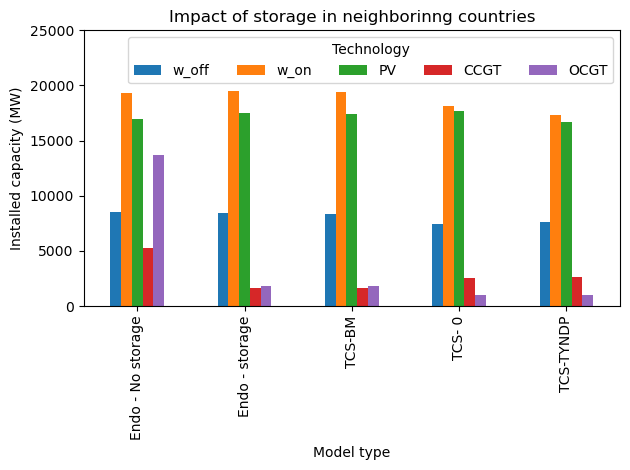

In [58]:
## Plot installed capacities 

# Define the types to include and order in which you want the types to appear
type_order = ["NTC-NS","NTC-S","TCS-S-BM","TCS-S-TYNDP"]
type_order = [name_map["NTC-S-All-True"],name_map["NTC-S-All-False"],name_map["TCS-All-100.0-endo_invest-False"],name_map["TCS-All-100.0-0-False"],name_map["TCS-All-100.0-TYNDP-False"]]

filter_condition = df_results["Model Type"].isin(type_order)

filtered_df = df_results[filter_condition].set_index("Model Type").reindex(type_order).reset_index()

#Choose the values to be displayed
stacked = False
if stacked: 
    vals= ["CCGT", "OCGT","PV","w_on","w_off"]
else:
    vals = [ "w_off", "w_on","PV","CCGT", "OCGT"]
#vals = ["imported","exported"]

plt.figure(figsize=(24, 12))

filtered_df.plot.bar(x="Model Type", y=vals, stacked=stacked)

plt.xlabel('Model type')
plt.ylabel('Installed capacity (MW)')
plt.title('Impact of storage in neighborinng countries')
plt.legend(title='Technology',ncols =5)
#plt.xticks(rotation=0) 
plt.ylim((0,25000))
plt.tight_layout()

#plt.show()
plt.savefig(f"../Results/Figures/PhD-Day/storage_caps.png")